Description
==

Right now image comparison is slow because I have to read in an image, vectorize it, and gray it before I compare it. I should just store the vector.


---
Flow:
- get image
- convert to gray
- find face
- subset on face
- save vector to postgres
- save full image to s3


In [11]:
import pickle
import boto3
import json
import cv2
import numpy as np
import cv2
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import psycopg2
import urllib.parse as urlparse
import os
## fast writes
from sqlalchemy import event, create_engine
import psycopg2.extras
import psycopg2.errorcodes

def open_connection():
    connection = psycopg2.connect(
        database=os.environ['RACK_DATABASE'],
        user=os.environ['RACK_USERNAME'],
        password=os.environ['RACK_PASSWORD'],
        host=os.environ['RACK_HOST'],
        port=os.environ['RACK_PORT']
        )
    return connection

engine = create_engine('postgresql://{}:{}@{}/{}'.format(os.environ['RACK_USERNAME'],
                                                            os.environ['RACK_PASSWORD'],
                                                            os.environ['RACK_HOST'],
                                                            os.environ['RACK_DATABASE']
                                                           ))

def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

haar_cascade_face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def get_gray(faces, image, gray):
    for (x,y,w,h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        image_gray = gray[y:y+h, x:x+w]
    return image_gray

def get_single_face(gray):
    for i in range(25):
        faces = haar_cascade_face.detectMultiScale(gray, 1.1, i)
        if len(faces) == 1:
            return faces, True
        elif len(faces) == 0:
            return [], False
    return [], False

In [142]:
victim_with_id = pd.read_sql_query("select * from victim_photo", open_connection())
victim_with_id.tail()

,id,url
26,62,http://www.pollyklaas.org/missing/kids/images/...
27,63,http://www.pollyklaas.org/missing/kids/images/...
28,64,http://www.pollyklaas.org/missing/kids/images/...
29,65,http://www.pollyklaas.org/missing/kids/images/...
30,35,http://www.pollyklaas.org/missing/kids/breitri...


In [135]:
def get_vector(id_):    
    ## get victim image
    sql_ = """
    SELECT url 
    FROM victim_photo
    WHERE id = {}
    """.format(id_)
    url = pd.read_sql_query(sql_, open_connection()).loc[0, 'url']
    file_name = url.split('/')[-1].split('.')[0]
    path = '../../data/victim/{}/{}.jpg'.format(id_, file_name)
    image = cv2.imread(path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces, found = get_single_face(gray)
    if found:
        return get_gray(faces, image, gray)
    else:
        return None

In [143]:
get_vector(35)

array([[19, 15, 14, ..., 36, 42, 57],
       [19, 17, 17, ..., 33, 34, 51],
       [17, 18, 20, ..., 37, 26, 45],
       ...,
       [17, 23, 19, ..., 17, 13, 20],
       [14, 18, 16, ..., 21, 13, 18],
       [14, 12, 10, ..., 33, 25, 27]], dtype=uint8)

In [144]:
victim_with_id['face_vector'] = victim_with_id['id'].apply(lambda row: [get_vector(row)])

In [145]:
victim_with_id.tail()

,id,url,face_vector
26,62,http://www.pollyklaas.org/missing/kids/images/...,"[[[4, 4, 4, 4, 6, 6, 7, 6, 4, 4, 4, 5, 5, 5, 9..."
27,63,http://www.pollyklaas.org/missing/kids/images/...,"[[[137, 142, 148, 152, 154, 149, 139, 128, 120..."
28,64,http://www.pollyklaas.org/missing/kids/images/...,"[[[47, 50, 51, 51, 50, 45, 43, 41, 40, 40, 40,..."
29,65,http://www.pollyklaas.org/missing/kids/images/...,"[[[31, 31, 34, 35, 36, 36, 36, 35, 34, 33, 33,..."
30,35,http://www.pollyklaas.org/missing/kids/breitri...,"[[[19, 15, 14, 16, 16, 14, 12, 21, 24, 19, 15,..."


In [309]:
def compare_images(gray_cap, gray_v, return_image=False):
    ## format image to compare
    H, W = gray_cap.shape
    gray_cap_area = H*W    

    
    ## prep for comparison
    H, W = np.shape(gray_v)
    image_area = H*W


    if gray_cap_area > image_area:
        gray_v = cv2.resize(gray_v, gray_cap.shape)
    elif gray_cap_area < image_area:
        gray_cap = cv2.resize(gray_cap, gray_v.shape)

    if return_image == False:
        return structural_similarity(gray_cap, gray_v)
    else:
        return structural_similarity(gray_cap, gray_v), image

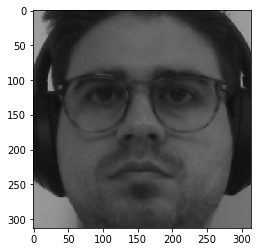

In [148]:
cap = cv2.VideoCapture(0)
ret, image_cap = cap.read()
gray = cv2.cvtColor(image_cap, cv2.COLOR_BGR2GRAY)
faces = haar_cascade_face.detectMultiScale(gray, 1.1, 2)
gray_cap = get_gray(faces, image_cap, gray)

H, W = gray_cap.shape
gray_cap_area = H*W

plt.imshow(convertToRGB(gray_cap))

In [172]:
compare_images(gray_cap, victim_with_id.loc[0, 'face_vector'], return_image=False)

0.5300665522014848

In [180]:
"update victim_photo SET face_vector = ([[1, 2, 3] [1, 2, 3]]) where id = 1010"

'update victim_photo SET face_vector = ([[1, 2, 3] [1, 2, 3]]) where id = 1010'

In [178]:
victim_with_id.loc[0, 'face_vector'][0]

array([[144, 137, 127, ...,  42,  42,  39],
       [149, 131, 126, ...,  44,  45,  40],
       [145, 126, 121, ...,  44,  46,  41],
       ...,
       [ 41,  40,  39, ...,  16,  17,  23],
       [ 41,  41,  39, ...,  17,  18,  14],
       [ 40,  41,  40, ...,  20,  21,  10]], dtype=uint8)

In [280]:
# kepp_this = victim_with_id.copy()
# kepp_this

In [293]:
victim_with_id = kepp_this.copy()
victim_with_id.tail()

,id,url,face_vector
26,62,http://www.pollyklaas.org/missing/kids/images/...,b'\x80\x03cnumpy.core.multiarray\n_reconstruct...
27,63,http://www.pollyklaas.org/missing/kids/images/...,b'\x80\x03cnumpy.core.multiarray\n_reconstruct...
28,64,http://www.pollyklaas.org/missing/kids/images/...,b'\x80\x03cnumpy.core.multiarray\n_reconstruct...
29,65,http://www.pollyklaas.org/missing/kids/images/...,b'\x80\x03cnumpy.core.multiarray\n_reconstruct...
30,35,http://www.pollyklaas.org/missing/kids/breitri...,b'\x80\x03cnumpy.core.multiarray\n_reconstruct...


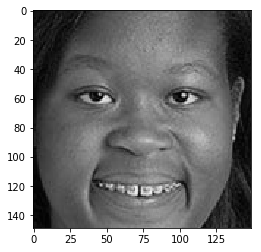

In [42]:
plt.imshow(convertToRGB(gray_v))

In [194]:
gray_v = get_vector(36)
gray_v

array([[144, 137, 127, ...,  42,  42,  39],
       [149, 131, 126, ...,  44,  45,  40],
       [145, 126, 121, ...,  44,  46,  41],
       ...,
       [ 41,  40,  39, ...,  16,  17,  23],
       [ 41,  41,  39, ...,  17,  18,  14],
       [ 40,  41,  40, ...,  20,  21,  10]], dtype=uint8)

In [195]:
victim_with_id['face_vector'] = None

In [196]:
victim_with_id.loc[i, 'face_vector'] = [gray_v]

In [216]:
import pickle

In [261]:
victim_with_id.loc[i, 'face_vector'] = str(pickle.dumps(gray_v))

In [274]:
victim_with_id['face_vector'] = victim_with_id['id'].apply(lambda row: str(pickle.dumps(get_vector(row))))

In [294]:
victim_with_id.to_sql('victim_photo', con=engine, if_exists='append', index=False)

In [312]:
tmp = pd.read_sql_query("select * from victim_photo", open_connection())
tmp['face_vector'] = tmp['face_vector'].apply(lambda row: pickle.loads(eval(row)))
tmp = tmp.loc[tmp['face_vector'].notnull()]
tmp.tail()

,id,url,face_vector
26,62,http://www.pollyklaas.org/missing/kids/images/...,"[[4, 4, 4, 4, 6, 6, 7, 6, 4, 4, 4, 5, 5, 5, 9,..."
27,63,http://www.pollyklaas.org/missing/kids/images/...,"[[137, 142, 148, 152, 154, 149, 139, 128, 120,..."
28,64,http://www.pollyklaas.org/missing/kids/images/...,"[[47, 50, 51, 51, 50, 45, 43, 41, 40, 40, 40, ..."
29,65,http://www.pollyklaas.org/missing/kids/images/...,"[[31, 31, 34, 35, 36, 36, 36, 35, 34, 33, 33, ..."
30,35,http://www.pollyklaas.org/missing/kids/breitri...,"[[19, 15, 14, 16, 16, 14, 12, 21, 24, 19, 15, ..."


Load and Compare
==

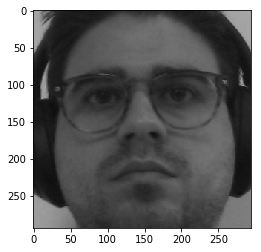

In [297]:
cap = cv2.VideoCapture(0)
ret, image_cap = cap.read()
gray = cv2.cvtColor(image_cap, cv2.COLOR_BGR2GRAY)
faces = haar_cascade_face.detectMultiScale(gray, 1.1, 2)
gray_cap = get_gray(faces, image_cap, gray)

H, W = gray_cap.shape
gray_cap_area = H*W

plt.imshow(convertToRGB(gray_cap))

In [310]:
compare_images(gray_cap, tmp.loc[0, 'face_vector'], return_image=False)

0.5033167884587845

In [315]:
now = pd.datetime.now()
tmp = pd.read_sql_query("select * from victim_photo", open_connection())
tmp['face_vector'] = tmp['face_vector'].apply(lambda row: pickle.loads(eval(row)))
tmp = tmp.loc[tmp['face_vector'].notnull()]
tmp['face_vector'].apply(lambda row: compare_images(gray_cap, row, return_image=False))
print(pd.datetime.now() - now)

0:00:01.351000
